In [1]:
import pandas as pd
import polars as pl
from data import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from missforest import MissForest
import pickle
from lightgbm import LGBMClassifier, LGBMRegressor
import pyarrow
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from scipy import stats
from typing import cast
from utils import *
import wrds

# 1. Fetching missing data

## 1.1. Reading all the predictor values

In [2]:
full_data = pl.read_csv(get_data_file_path("signed_predictors_all_wide.csv"), dtypes=ALL_DATA_ENTRY_SCHEMA)
full_data = full_data.sort(by=["permno", "yyyymm"], maintain_order=True)
full_data.insert_column(2, full_data["yyyymm"].str.to_date("%Y%m").alias("date"))
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,Spinoff,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10000,"""198512""",1985-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null
10000,"""198601""",1986-01-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,-0.005234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-1.475907,-9.686575
10000,"""198602""",1986-02-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,-0.003488,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.7852e-8,null,25.7143,-1.178655,-9.389323
10000,"""198603""",1986-03-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,-0.002715,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0234e-7,null,-36.5385,-1.490091,-9.700759
10000,"""198604""",1986-04-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,0.000877,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.4675e-8,null,9.8592,-1.386294,-9.627207
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,"""202401""",2024-01-01,null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,…,null,0.0,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511,null,null,null,null,null,-0.251513,null,null,null,null,null,null,null,null,null,0.698178,null,null,null,null,null,null
93436,"""202402""",2024-02-01,null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,…,null,0.0,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511,null,null,null,null,null,-0.251513,null,null,null,null,null,null,null,null,null,0.698178,nu

## 1.2. Fetching the missing monthly returns from WRDS

In [3]:
MIN_DATE = full_data["date"].min()
MAX_DATE = full_data["date"].max()
MIN_PERMNO = full_data["permno"].min()
MAX_PERMNO = full_data["permno"].max()

db = wrds.Connection(wrds_username=get_env("WRDS_USERNAME"))

# Query to get the stock returns
query = f"""
SELECT permno, mthcaldt, mthret
FROM crsp.msf_v2
WHERE permno BETWEEN {MIN_PERMNO} AND {MAX_PERMNO}
AND mthcaldt BETWEEN '{MIN_DATE.strftime("%Y-%m-%d")}' AND '{MAX_DATE.strftime("%Y-%m-%d")}'
"""

# Execute the query
all_returns_data = pl.DataFrame(db.raw_sql(query))

# Close the connection
db.close()

Loading library list...
Done


## 1.3. Analyzing the return values

In [14]:
all_returns_data.insert_column(1, pl.Series("yyyymm", all_returns_data.get_column("mthcaldt").apply(lambda x: x.strftime("%Y%m"))))
all_returns_data = all_returns_data.rename({"mthcaldt": "date", "mthret": "ret"})
all_returns_data

permno,yyyymm,date,ret
i64,str,date,f64
10000,"""198601""",1986-01-31,0.707317
10000,"""198602""",1986-02-28,-0.257143
10000,"""198603""",1986-03-31,0.365385
10000,"""198604""",1986-04-30,-0.098592
10000,"""198605""",1986-05-30,-0.222656
…,…,…,…
93436,"""202308""",2023-08-31,-0.034962
93436,"""202309""",2023-09-29,-0.030456
93436,"""202310""",2023-10-31,-0.197346


### Displaying summary statistics

In [15]:
all_returns_data.describe()

statistic,permno,yyyymm,date,ret
str,f64,str,str,f64
"""count""",5.001721e6,"""5001721""","""5001721""",4.91856e6
"""null_count""",0.0,"""0""","""0""",83161.0
"""mean""",52557.890819,null,"""1994-02-19""",0.009909
"""std""",29509.729138,null,null,0.172307
"""min""",10000.0,"""192512""","""1925-12-31""",-1.0
"""25%""",20969.0,null,"""1982-01-29""",-0.057826
"""50%""",54894.0,null,"""1996-10-31""",0.0
"""75%""",80717.0,null,"""2010-05-28""",0.062112
"""max""",93436.0,"""202312""","""2023-12-29""",24.0


### Retrieving the percentage of nulls in each column

In [16]:
all_returns_data.null_count() / len(all_returns_data)

permno,yyyymm,date,ret
f64,f64,f64,f64
0.0,0.0,0.0,0.016626


### Saving the return values in the `data/` directory.

In [24]:
all_returns_data.write_csv(get_data_file_path("1_3_all_returns_values.csv"))

## 1.4. Joining the returns with the original data

In [21]:
full_data = full_data.join(all_returns_data, on=("permno", "yyyymm"))
full_data = full_data.sort(by=["permno", "yyyymm"], maintain_order=True)
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date_right,ret
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date,f64
10000,"""198601""",1986-01-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,-0.005234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-1.475907,-9.686575,1986-01-31,0.707317
10000,"""198602""",1986-02-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,-0.003488,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.7852e-8,null,25.7143,-1.178655,-9.389323,1986-02-28,-0.257143
10000,"""198603""",1986-03-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,-0.002715,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0234e-7,null,-36.5385,-1.490091,-9.700759,1986-03-31,0.365385
10000,"""198604""",1986-04-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,0.000877,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.4675e-8,null,9.8592,-1.386294,-9.627207,1986-04-30,-0.098592
10000,"""198605""",1986-05-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,0.008818,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.6496e-8,null,22.2656,-1.134423,-9.375336,1986-05-30,-0.222656
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,"""202308""",2023-08-01,null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,…,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511,null,null,null,null,null,-0.251513,null,null,null,null,null,null,null,null,null,0.698178,null,null,null,3.4962,-5.55327,-20.523771,2023-08-31,-0.034962
93436,"""202309""",2023-09-01,null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,…,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511

### Saving the return values in the `data/` directory.

In [25]:
full_data.write_csv(get_data_file_path("1_4_complete_dataset.csv"))

<hr>

# 2. Analysis and cleaning of full dataset

## 2.1 Analysis

### Retrieving the previously computed data and analyzing it

In [2]:
full_data = pl.read_csv(get_data_file_path("1_4_complete_dataset.csv"), dtypes=ALL_DATA_WITH_DATES_ENTRY_SCHEMA)

### Summary statistics

In [3]:
full_data.describe()

statistic,permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,…,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date_right,ret
str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
"""count""",5.001719e6,"""5001719""","""5001719""",2.934379e6,1.15785e6,2.315298e6,2.958277e6,213321.0,108731.0,30170.0,1.005624e6,323539.0,1.831642e6,1.15785e6,2.799989e6,2.991829e6,2.63683e6,2.885026e6,2.821225e6,4.090423e6,3.630244e6,3.260315e6,2.23001e6,4.254861e6,3.28373e6,429185.0,2.213547e6,2.934379e6,665346.0,2.007255e6,2.899112e6,2.285172e6,2.783762e6,598245.0,2.991871e6,2.58679e6,…,2.918468e6,2.85058e6,2.002865e6,443513.0,2.460418e6,4.147365e6,3.733413e6,3.482626e6,2.72809e6,3.141841e6,2.510236e6,797950.0,2.8926e6,797950.0,797950.0,840921.0,2.345021e6,2.139236e6,3.179055e6,1.56695e6,1.567902e6,1.377169e6,707340.0,2.393689e6,561785.0,229562.0,458208.0,2.064645e6,1.398719e6,4.288348e6,4.453415e6,4.035377e6,5.001692e6,4.889704e6,4.889704e6,"""5001719""",4.91856e6
"""null_count""",0.0,"""0""","""0""",2.06734e6,3.843869e6,2.686421e6,2.043442e6,4.788398e6,4.892988e6,4.971549e6,3.996095e6,4.67818e6,3.170077e6,3.843869e6,2.20173e6,2.00989e6,2.364889e6,2.116693e6,2.180494e6,911296.0,1.371475e6,1.741404e6,2.771709e6,746858.0,1.717989e6,4.572534e6,2.788172e6,2.06734e6,4.336373e6,2.994464e6,2.102607e6,2.716547e6,2.217957e6,4.403474e6,2.009848e6,2.414929e6,…,2.083251e6,2.151139e6,2.998854e6,4.558206e6,2.541301e6,854354.0,1.268306e6,1.519093e6,2.273629e6,1.859878e6,2.491483e6,4.203769e6,2.109119e6,4.203769e6,4.203769e6,4.160798e6,2.656698e6,2.862483e6,1.822664e6,3.434769e6,3.433817e6,3.62455e6,4.294379e6,2.60803e6,4.439934e6,4.772157e6,4.543511e6,2.937074e6,3.603e6,713371.0,548304.0,966342.0,27.0,112015.0,112015.0,"""0""",83159.0
"""mean""",52557.900542,null,"""1994-01-21""",3.679108,-167.987622,-0.002054,0.028987,0.483201,14.8865,9.263089,0.075071,18.541335,1.006447,0.761476,0.00265,-0.185045,-0.726098,2.955279,0.010867,0.989357,0.973176,-0.000942,0.641241,0.016827,-4.035381,-2648.250887,0.093091,0.009326,-0.009441,0.163636,12.959522,-0.114969,-1.316419,0.4765,-0.0111,1184.470452,…,1.175541,-0.009572,0.215255,0.352181,-0.86924,-0.170444,-4.678983,-0.005833,-0.0624,-0.00046,0.004548,0.000138,-0.10406,0.000396,-0.000534,-16.736662,-3.378635,-3.0530e10,-0.041825,1.725571,1.59892,-5.7231e-11,0.010877,-0.007297,0.005598,0.17759,-0.067404,-0.168298,0.692553,1.483897,1.569698,1.417248,-0.960276,-2.494829,inf,"""1994-02-19""",0.009909
"""std""",29509.729822,null,null,27.076367,49157.458375,0.149407,0.124682,0.499719,2.724359,12.642133,0.361158,22.924938,4.870561,1.531836,0.100687,2.79736,1.036695,53.156871,337.991427,0.740854,0.637415,0.453464,0.512396,0.031688,201.550732,73207.538788,0.21609,2.369586,0.063112,0.210208,3878.866638,287.115892,13.690896,0.499448,0.065513,5.8564e13,…,19.164663,0.787955,0.161514,0.477651,54.319368,1.64321,35.824533,0.020629,0.487959,0.017131,1.51171,0.193816,1.993336,0.182771,0.185065,12.008629,342.849539,5.6119e13,0.270094,5.96922,5.223386,0.248011,0.083283,0.291099,1.49462,0.382168,0.084423,2.47323,0.181363,3.309599,3.696146,3.127223,17.002457,1.282335,NaN,null,0.172307
"""min""",10000.0,"""192512""","""1925-12-01""",0.0,-1.5267176e7,-2.809462,-11.619047,0.

### Number of nulls in each column

In [4]:
full_data.null_count()

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date_right,ret
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,2067340,3843869,2686421,2043442,4788398,4892988,4971549,3996095,4678180,3170077,3843869,2201730,2009890,2364889,2116693,2180494,911296,1371475,1741404,2771709,746858,1717989,4572534,2788172,2067340,4336373,2994464,2102607,2716547,2217957,4403474,2009848,2414929,4808032,…,2083251,2151139,2998854,4558206,2541301,854354,1268306,1519093,2273629,1859878,2491483,4203769,2109119,4203769,4203769,4160798,2656698,2862483,1822664,3434769,3433817,3624550,4294379,2608030,4439934,4772157,4543511,2937074,3603000,713371,548304,966342,27,112015,112015,0,83159


### Percentage of non-null elements in each column

In [5]:
full_data.count() / len(full_data)

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date_right,ret
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,1.0,0.586674,0.23149,0.4629,0.591452,0.04265,0.021739,0.006032,0.201056,0.064686,0.366202,0.23149,0.559805,0.59816,0.527185,0.576807,0.564051,0.817803,0.725799,0.651839,0.445849,0.85068,0.65652,0.085807,0.442557,0.586674,0.133023,0.401313,0.579623,0.456877,0.556561,0.119608,0.598169,0.51718,0.038724,…,0.583493,0.56992,0.400435,0.088672,0.491914,0.829188,0.746426,0.696286,0.54543,0.628152,0.501875,0.159535,0.578321,0.159535,0.159535,0.168126,0.468843,0.4277,0.635592,0.313282,0.313473,0.275339,0.141419,0.478573,0.112318,0.045897,0.09161,0.412787,0.279648,0.857375,0.890377,0.806798,0.999995,0.977605,0.977605,1.0,0.983374


## 2.2 Cleaning of nulls

### Defining a function to drop columns with a high number of nulls

In [6]:
def drop_high_null_columns(data: pl.DataFrame, /, *, null_threshold: float) -> pl.DataFrame:
    """Function that returns a new dataframe where columns exceeding a certain percentage of nulls are dropped.
    The function is out-of-place and does not modify the original data.

    :param data: The dataframe to analyze.
    :param null_threshold: The threshold of nulls to use, columns with a higher percentage will be dropped in the result.
    :return: The dataframe with high-nulls columns dropped.
    """
    if null_threshold < 0.0 or null_threshold > 1.0:
        raise ValueError("Null threshold should be between 0 and 1")
    missing_percentage = data.select(pl.all().is_null().mean()).to_pandas().iloc[0]
    columns_to_drop = missing_percentage[missing_percentage > null_threshold].index
    return data.drop(columns_to_drop)

### Dropping columns with over 50% of nulls

In [7]:
full_data = drop_high_null_columns(full_data, null_threshold=0.5)
full_data

permno,yyyymm,date,AM,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BidAskSpread,BookLeverage,CF,CashProd,ChEQ,ChInv,ChInvIA,ChNNCOA,ChNWC,ChTax,ConvDebt,CoskewACX,Coskewness,DebtIssuance,DelCOA,DelCOL,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,DolVol,EBM,…,NetDebtFinance,NetEquityFinance,NumEarnIncrease,OPLeverage,PctAcc,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,RDIPO,RealizedVol,ResidualMomentum,ReturnSkew,ReturnSkew3F,RoE,SP,ShareIss1Y,ShareIss5Y,ShareRepurchase,Spinoff,Tax,TotalAccruals,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dNoa,hire,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date_right,ret
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date,f64
10000,"""198601""",1986-01-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,null,…,null,null,null,null,null,null,null,null,null,-0.065278,null,-2.23832,-2.103353,null,null,null,null,null,0.0,null,null,null,null,null,null,-0.005234,null,null,null,null,null,null,0.0,-1.475907,-9.686575,1986-01-31,0.707317
10000,"""198602""",1986-02-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,null,…,null,null,null,null,null,null,null,null,null,-0.031004,null,0.729555,0.810187,null,null,null,null,null,0.0,null,null,null,null,null,null,-0.003488,null,null,null,null,4.7852e-8,null,25.7143,-1.178655,-9.389323,1986-02-28,-0.257143
10000,"""198603""",1986-03-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.255134,null,…,null,null,null,null,null,null,null,null,null,-0.044548,null,-1.6879,-1.038325,null,null,null,null,null,0.0,null,null,null,null,null,null,-0.002715,null,null,null,null,1.0234e-7,null,-36.5385,-1.490091,-9.700759,1986-03-31,0.365385
10000,"""198604""",1986-04-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,1.3126723,null,…,null,null,null,null,null,null,null,null,null,-0.011246,null,0.276167,0.068097,null,null,null,null,null,0.0,null,null,null,null,null,null,0.000877,null,null,null,null,7.4675e-8,null,9.8592,-1.386294,-9.627207,1986-04-30,-0.098592
10000,"""198605""",1986-05-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.737386,null,…,null,null,null,null,null,null,null,null,null,-0.038863,null,-1.289032,-0.738724,null,null,null,null,null,0.0,null,null,null,null,null,null,0.008818,null,null,null,null,7.6496e-8,null,22.2656,-1.134423,-9.375336,1986-05-30,-0.222656
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,"""202308""",2023-08-01,null,0.016862,null,-0.325232,null,null,null,null,null,null,null,-1.838476,null,null,-1.480804,-0.098042,null,0.097266,-0.063707,-0.001368,0.0,null,null,null,-0.129993,-0.096547,-0.200943,0.043262,-0.019852,0.142716,null,null,null,null,…,0.05352,-0.007489,null,0.775863,0.172666,null,null,null,0.0,null,null,null,null,0.28087,null,null,null,0.0,null,0.288081,-0.223286,null,null,null,0.040382,null,null,-0.109511,-0.251513,null,null,null,3.4962,-5.55327,-20.523771,2023-08-31,-0.034962
93436,"""202309""",2023-09-01,null,0.016862,null,-0.325232,null,null,null,null,null,null,null,-1.838476,null,null,-1.480804,-0.098042,null,0.097266,-0.063707,0.001899,0.0,null,null,null,-0.129993,-0.096547,-

### Get percentage of non-null elements in each column

In [8]:
full_data.count() / len(full_data)

permno,yyyymm,date,AM,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BidAskSpread,BookLeverage,CF,CashProd,ChEQ,ChInv,ChInvIA,ChNNCOA,ChNWC,ChTax,ConvDebt,CoskewACX,Coskewness,DebtIssuance,DelCOA,DelCOL,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,DolVol,EBM,…,NetDebtFinance,NetEquityFinance,NumEarnIncrease,OPLeverage,PctAcc,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,RDIPO,RealizedVol,ResidualMomentum,ReturnSkew,ReturnSkew3F,RoE,SP,ShareIss1Y,ShareIss5Y,ShareRepurchase,Spinoff,Tax,TotalAccruals,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dNoa,hire,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date_right,ret
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,1.0,0.586674,0.591452,0.559805,0.59816,0.527185,0.576807,0.564051,0.817803,0.725799,0.651839,0.85068,0.65652,0.586674,0.579623,0.556561,0.598169,0.51718,0.588919,0.591432,0.531485,0.65995,0.794012,0.879736,0.528517,0.598169,0.591452,0.57833,0.589848,0.598169,0.589848,0.785426,0.785426,0.882836,0.564051,…,0.500695,0.518174,0.544126,0.656695,0.57273,0.883371,0.883371,0.863173,0.65995,0.951837,0.661866,0.944935,0.950179,0.640893,0.585219,0.681609,0.504168,0.65995,0.785426,0.583493,0.56992,0.829188,0.746426,0.696286,0.54543,0.628152,0.501875,0.578321,0.635592,0.857375,0.890377,0.806798,0.999995,0.977605,0.977605,1.0,0.983374


### Saving cleaned dataset to the `/data` folder

In [9]:
full_data.write_csv(get_data_file_path("2_2_cleaned_dataset.csv"))

<hr>

# 3. Imputation and normalization of data

## 3.1. Defining the miss forest implementation

### Retrieving data from the previous section

In [2]:
full_data = pd.read_csv(get_data_file_path("2_2_cleaned_dataset.csv"))
full_data

,permno,yyyymm,date,AM,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,...,dNoa,hire,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date_right,ret
0,10000,198601,1986-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0000,-1.475907,-9.686575,1986-01-31,0.707317
1,10000,198602,1986-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.785175e-08,NaN,25.7143,-1.178655,-9.389323,1986-02-28,-0.257143
2,10000,198603,1986-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.023392e-07,NaN,-36.5385,-1.490091,-9.700759,1986-03-31,0.365385
3,10000,198604,1986-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.467463e-08,NaN,9.8592,-1.386294,-9.627207,1986-04-30,-0.098592
4,10000,198605,1986-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.649551e-08,NaN,22.2656,-1.134423,-9.375336,1986-05-30,-0.222656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5001714,93436,202308,2023-08-01,NaN,0.016862,NaN,-0.325232,NaN,NaN,NaN,...,-0.109511,-0.251513,NaN,NaN,NaN,3.4962,-5.553270,-20.523771,2023-08-31,-0.034962
5001715,93436,202309,2023-09-01,NaN,0.016862,NaN,-0.325232,NaN,NaN,NaN,...,-0.109511,-0.251513,NaN,NaN,NaN,3.0456,-5.522341,-20.494418,2023-09-29,-0.030456
5001716,93436,202310,2023-10-01,NaN,0.016862,NaN,-0.325232,NaN,NaN,NaN,...,-0.109511,-0.251513,NaN,NaN,NaN,19.7346,-5.302509,-20.274561,2023-10-31,-0.197346
5001717,93436,202311,2023-11-01,NaN,0.016862,NaN,-0.325232,NaN,NaN,NaN,...,-0.109511,-0.251513,NaN,NaN,NaN,-19.5379,-5.480972,-20.453025,2023-11-30,0.195379


### Defining the miss forest imputation function

In [3]:
NON_VALUE_ATTRIBUTES = ["permno", "yyyymm", "date", "date_right"]

def miss_forest_impute(df: pd.DataFrame, /, *, n_estimators: int, seed: int = 0) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan, inplace=False)
    dropped_df = df.drop(columns=NON_VALUE_ATTRIBUTES)
    imputer = MissForest(
        n_estimators=n_estimators,
        random_state=seed,
        criterion=("squared_error", "gini"),
        max_features="sqrt",
        verbose=True
    )
    return pd.concat([df[NON_VALUE_ATTRIBUTES], pd.DataFrame(imputer.fit_transform(dropped_df), columns=dropped_df.columns)], axis=1)

## 3.2. Executing the miss forest implementation

### Running the function on our cleaned dataset

<p style="color: #FFC107">⚠️ WARNING: The execution of the function takes over 3 hours.</p>

In [4]:
full_data_imputed = miss_forest_impute(full_data, n_estimators=10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   55.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent 

Iteration: 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent 

Iteration: 1


### Peeking at the imputed data

In [5]:
full_data_imputed

,permno,yyyymm,date,date_right,AM,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,cfp,dNoa,hire,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10000,198601,1986-01-01,1986-01-31,16.202734,0.001839,-0.035723,-0.083313,0.210250,1.404658,...,0.069862,-0.047715,0.000000,6.591505,6.951966e+00,5.942311,0.0000,-1.475907,-9.686575,0.707317
1,10000,198602,1986-02-01,1986-02-28,6.419575,0.023401,-0.024668,-0.053147,-0.578258,1.615003,...,0.168980,-0.063516,0.000000,0.697140,4.785175e-08,0.967149,25.7143,-1.178655,-9.389323,-0.257143
2,10000,198603,1986-03-01,1986-03-31,9.672034,0.019860,0.028711,-0.298639,-0.365597,0.831680,...,0.256035,-0.089197,0.000000,0.522273,1.023392e-07,1.036358,-36.5385,-1.490091,-9.700759,0.365385
3,10000,198604,1986-04-01,1986-04-30,34.015608,0.005994,-0.025540,-0.086369,0.401779,3.266376,...,0.084696,-0.051597,0.000000,2.197636,7.467463e-08,2.679387,9.8592,-1.386294,-9.627207,-0.098592
4,10000,198605,1986-05-01,1986-05-30,8.585498,0.012495,-0.045491,-0.016131,-0.351601,2.188701,...,0.363375,-0.053943,0.000000,0.515208,7.649551e-08,0.367705,22.2656,-1.134423,-9.375336,-0.222656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5001714,93436,202308,2023-08-01,2023-08-31,3.018393,0.016862,-0.011255,-0.325232,-0.237770,15.468266,...,0.209852,-0.109511,-0.251513,7.378857,5.330302e+00,6.284016,3.4962,-5.553270,-20.523771,-0.034962
5001715,93436,202309,2023-09-01,2023-09-29,2.761402,0.016862,-0.013155,-0.325232,-0.227470,5.535130,...,0.227440,-0.109511,-0.251513,6.029153,5.273759e+00,5.027825,3.0456,-5.522341,-20.494418,-0.030456
5001716,93436,202310,2023-10-01,2023-10-31,3.311023,0.016862,-0.017331,-0.325232,-0.929634,1.407850,...,0.089645,-0.109511,-0.251513,0.705781,2.000000e-01,0.698125,19.7346,-5.302509,-20.274561,-0.197346
5001717,93436,202311,2023-11-01,2023-11-30,2.891101,0.016862,0.043047,-0.325232,-0.470768,5.577071,...,0.299735,-0.109511,-0.251513,2.502209,2.301306e+00,3.123486,-19.5379,-5.480972,-20.453025,0.195379


### Saving the result to the `data/` directory

In [6]:
full_data_imputed.to_csv(get_data_file_path("3_2_imputed_dataset.csv"))
full_data_imputed.to_parquet(get_data_file_path("3_2_imputed_dataset.parquet"), engine="pyarrow", index=False)

## 3.3. Analysis of results

### Reading imputed data from file

In [2]:
# full_data_imputed = pl.read_csv(get_data_file_path("3_2_imputed_dataset.csv")).drop("").to_pandas()
full_data_imputed = pd.read_parquet(get_data_file_path("3_2_imputed_dataset.parquet"), engine="pyarrow")

### Make sure there are no missing values

In [3]:
has_any_na(full_data_imputed)

False

## 3.4. Normalizing Data

### Defining the code for normalization

In [4]:
NON_VALUE_ATTRIBUTES = ["permno", "yyyymm", "date", "date_right"]

def normalize(df: pd.DataFrame, /) -> pd.DataFrame:
    dropped_df = df.drop(columns=NON_VALUE_ATTRIBUTES)
    scaled_df = StandardScaler().fit_transform(dropped_df)
    return pd.concat([df[NON_VALUE_ATTRIBUTES], pd.DataFrame(scaled_df, columns=dropped_df.columns)], axis=1)

### Normalizing the dataset

In [5]:
full_data_imputed_scaled = normalize(full_data_imputed)
full_data_imputed_scaled

,permno,yyyymm,date,date_right,AM,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,cfp,dNoa,hire,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10000,198601,1986-01-01,1986-01-31,0.305054,-0.145887,-0.495159,0.034450,0.824864,-0.063867,...,0.001842,0.024834,0.126962,1.380278,1.373552,1.235832,0.056477,0.796207,0.815048,4.077568
1,10000,198602,1986-02-01,1986-02-28,-0.030245,0.060377,-0.355937,0.048380,-0.016301,-0.059604,...,0.083521,0.014416,0.126962,-0.312387,-0.481887,-0.241796,1.568865,1.029646,0.945737,-1.563945
2,10000,198603,1986-03-01,1986-03-31,0.081227,0.026502,0.316305,-0.064983,0.210562,-0.075480,...,0.155258,-0.002516,0.126962,-0.362603,-0.481887,-0.221241,-2.092537,0.785068,0.808811,2.077470
3,10000,198604,1986-04-01,1986-04-30,0.915557,-0.106135,-0.366915,0.033039,1.029184,-0.026134,...,0.014066,0.022274,0.126962,0.118505,-0.481887,0.266740,0.636347,0.866582,0.841149,-0.636517
4,10000,198605,1986-05-01,1986-05-30,0.043988,-0.043953,-0.618170,0.065473,0.225492,-0.047976,...,0.243711,0.020728,0.126962,-0.364631,-0.481887,-0.419832,1.366030,1.064382,0.951887,-1.362217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5001714,93436,202308,2023-08-01,2023-08-31,-0.146815,-0.002177,-0.187018,-0.077263,0.346925,0.221170,...,0.117201,-0.015910,-1.031321,1.606379,0.940739,1.337319,0.262106,-2.405839,-3.949625,-0.264320
5001715,93436,202309,2023-09-01,2023-09-29,-0.155622,-0.002177,-0.210946,-0.077263,0.357912,0.019848,...,0.131694,-0.015910,-1.031321,1.218789,0.925648,0.964229,0.235604,-2.381550,-3.936719,-0.237962
5001716,93436,202310,2023-10-01,2023-10-31,-0.136785,-0.002177,-0.263533,-0.077263,-0.391143,-0.063802,...,0.018145,-0.015910,-1.031321,-0.309905,-0.428509,-0.321697,1.217169,-2.208911,-3.840057,-1.214169
5001717,93436,202311,2023-11-01,2023-11-30,-0.151177,-0.002177,0.496843,-0.077263,0.098368,0.020698,...,0.191269,-0.015910,-1.031321,0.205969,0.132318,0.398638,-1.092646,-2.349063,-3.918520,1.083037


### Make sure we don't have any NaNs

In [6]:
has_any_na(full_data_imputed_scaled)

False

### Save the result to the `data/` directory

In [7]:
full_data_imputed_scaled.to_parquet(get_data_file_path("3_4_normalized_dataset.parquet"), engine="pyarrow", index=False)

<hr>

# 4. Training

In [18]:
full_data_imputed = read_from_parquet("3_2_imputed_dataset.parquet")
full_data_imputed

,permno,yyyymm,date,date_right,AM,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,cfp,dNoa,hire,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10000,198601,1986-01-01,1986-01-31,16.202734,0.001839,-0.035723,-0.083313,0.210250,1.404658,...,0.069862,-0.047715,0.000000,6.591505,6.951966e+00,5.942311,0.0000,-1.475907,-9.686575,0.707317
1,10000,198602,1986-02-01,1986-02-28,6.419575,0.023401,-0.024668,-0.053147,-0.578258,1.615003,...,0.168980,-0.063516,0.000000,0.697140,4.785175e-08,0.967149,25.7143,-1.178655,-9.389323,-0.257143
2,10000,198603,1986-03-01,1986-03-31,9.672034,0.019860,0.028711,-0.298639,-0.365597,0.831680,...,0.256035,-0.089197,0.000000,0.522273,1.023392e-07,1.036358,-36.5385,-1.490091,-9.700759,0.365385
3,10000,198604,1986-04-01,1986-04-30,34.015608,0.005994,-0.025540,-0.086369,0.401779,3.266376,...,0.084696,-0.051597,0.000000,2.197636,7.467463e-08,2.679387,9.8592,-1.386294,-9.627207,-0.098592
4,10000,198605,1986-05-01,1986-05-30,8.585498,0.012495,-0.045491,-0.016131,-0.351601,2.188701,...,0.363375,-0.053943,0.000000,0.515208,7.649551e-08,0.367705,22.2656,-1.134423,-9.375336,-0.222656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5001714,93436,202308,2023-08-01,2023-08-31,3.018393,0.016862,-0.011255,-0.325232,-0.237770,15.468266,...,0.209852,-0.109511,-0.251513,7.378857,5.330302e+00,6.284016,3.4962,-5.553270,-20.523771,-0.034962
5001715,93436,202309,2023-09-01,2023-09-29,2.761402,0.016862,-0.013155,-0.325232,-0.227470,5.535130,...,0.227440,-0.109511,-0.251513,6.029153,5.273759e+00,5.027825,3.0456,-5.522341,-20.494418,-0.030456
5001716,93436,202310,2023-10-01,2023-10-31,3.311023,0.016862,-0.017331,-0.325232,-0.929634,1.407850,...,0.089645,-0.109511,-0.251513,0.705781,2.000000e-01,0.698125,19.7346,-5.302509,-20.274561,-0.197346
5001717,93436,202311,2023-11-01,2023-11-30,2.891101,0.016862,0.043047,-0.325232,-0.470768,5.577071,...,0.299735,-0.109511,-0.251513,2.502209,2.301306e+00,3.123486,-19.5379,-5.480972,-20.453025,0.195379


In [24]:
def split_into_x_and_y(df: pd.DataFrame, /, *, y_column_name: str, ignoring_columns: list[str]) -> tuple[pd.DataFrame, pd.Series]:
    if y_column_name in ignoring_columns:
        raise ValueError(f"Cannot ignore and select '{y_column_name}' as y column")
    y = df[y_column_name]
    X = df.drop(columns=ignoring_columns + [y_column_name], inplace=False)
    return (X, y)

In [25]:
def run_models_and_plot(df: pd.DataFrame, /, *, y_column_name: str, ignoring_columns: list[str], test_size: float = 0.2, seed: int = 0):
    X, y = split_into_x_and_y(df, y_column_name=y_column_name, ignoring_columns=ignoring_columns)

    # Normalize the features
    X = StandardScaler().fit_transform(X)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    # Create and fit models
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(alpha=0.1),
        "Random Forest Regressor": RandomForestRegressor(),
        "Ada Boost Regressor": AdaBoostRegressor(),
    }

    # Make predictions using each model and plot observed vs fitted values
    for name, model in models.items():
        model.fit(X_train, y_train)
        if name == "Lasso":
            print(model.coef_)
        predictions = model.predict(X_test)

        # Plot observed vs fitted values
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, predictions)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
        plt.xlabel("Observed")
        plt.ylabel("Fitted")
        plt.title(name)
        plt.show()

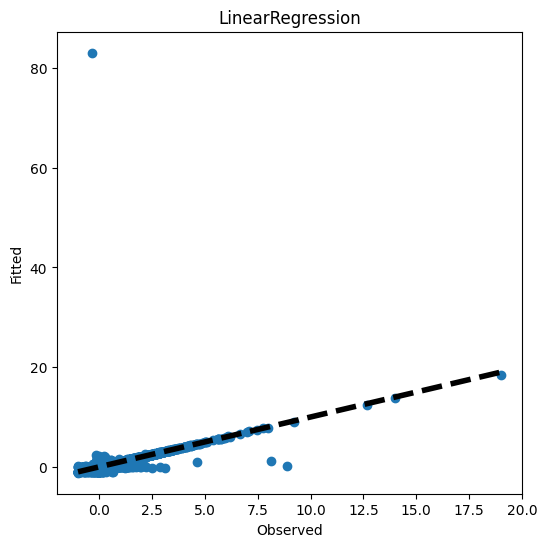

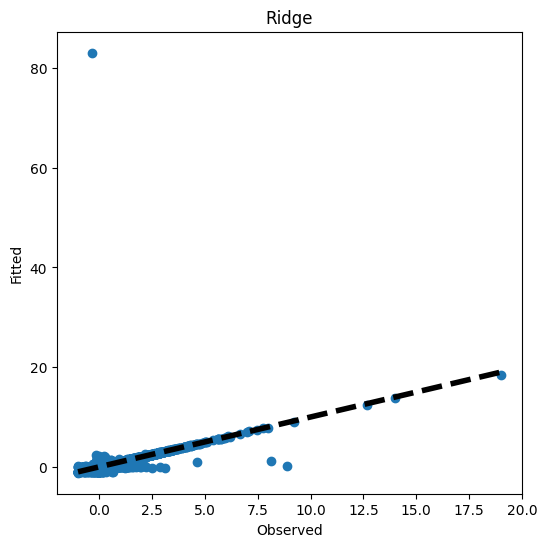

[-0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.
  0.         -0.          0.          0.         -0.         -0.
 -0.          0.          0.         -0.         -0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.         -0.          0.          0.
 -0.          0.          0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.          0.
  0.          0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.          0.          0.          0.
  0.          0.         

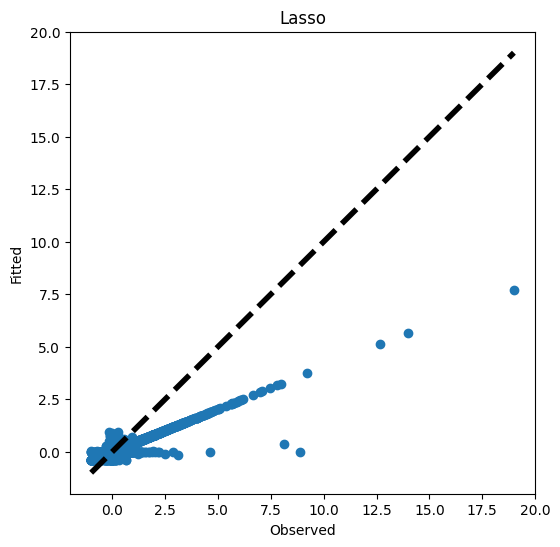

In [26]:
run_models_and_plot(full_data_imputed, y_column_name="ret", ignoring_columns=["permno", "yyyymm", "date", "date_right"])